# side model feature selection

In [1]:
import pandas as pd

df_features = pd.read_parquet("data/features_45m.parquet")
print(df_features.shape)
df_features.isna().sum(axis=0).sort_values(ascending=False)

(59138, 11841)


4h_williams_r_ddt_lag39         538
4h_acc_swing_index_lag22        538
4h_hurst_coef_fast_ddt_lag21    538
4h_hurst_coef_fast_ddt_lag20    538
4h_hurst_coef_fast_ddt_lag19    538
                               ... 
45m_mod_stochastic                0
45m_conv_5                        0
45m_conv_4                        0
45m_conv_3                        0
45m_ac_45                         0
Length: 11841, dtype: int64

In [2]:
import numpy as np
from jesse import utils

label = np.load("data/label_side_45m.npy")
df_label = utils.numpy_candles_to_dataframe(label[:, :6]).set_index("date")
df_label["side_label"] = label[:, 6]
df_label.head(1)

,open,close,high,low,volume,side_label
date,,,,,,
2020-01-01 01:22:00,7188.72,7185.59,7260.43,7174.0,52620.421,-1.0


In [3]:
side_features = df_features.iloc[538:]
side_label = df_label.iloc[538:]

side_label["side_label"] = (side_label["side_label"].astype(int) == 1).astype(int)
side_label = side_label["side_label"].to_numpy()

print(side_features.shape)
print(side_label.shape)

side_features.isna().sum(axis=0).sort_values(ascending=False)

/var/folders/2g/md1t2j7s6hjdjc5jlvkmn7_c0000gn/T/ipykernel_31588/2579419160.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  side_label["side_label"] = (side_label["side_label"].astype(int) == 1).astype(int)


(58600, 11841)
(58600,)


15m_ac_0                    0
4h_ac_4                     0
45m_williams_r_ddt_lag35    0
45m_williams_r_ddt_lag36    0
45m_williams_r_ddt_lag37    0
                           ..
45m_ac_2                    0
45m_ac_3                    0
45m_ac_4                    0
45m_ac_5                    0
4h_williams_r_ddt_lag39     0
Length: 11841, dtype: int64

In [4]:
# from feature_engine.selection import SelectByInformationValue
# from tqdm.auto import tqdm

# iv_final = {}
# features_list = list(side_features.columns)
# for i in tqdm(range(0, len(features_list), 100)):
#     batch_features = features_list[i : i + 100]
#     sel = SelectByInformationValue(
#         variables=batch_features,
#         bins=5,
#         strategy="equal_frequency",
#         threshold=0.02,
#     )
#     sel.fit(side_features, side_label)
#     iv_final = {**iv_final, **sel.information_values_}

/opt/homebrew/Caskroom/miniforge/base/envs/jesse/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 119/119 [06:28<00:00,  3.26s/it]


In [4]:
from feature_engine.selection import MRMR

sel = MRMR(
    method="FCQ",
    max_features=side_features.shape[1] // 2,
    scoring="f1",
    cv=4,
    regression=False,
    n_jobs=-1,
)
sel.fit(side_features, side_label)

MRMR(cv=4, max_features=5920, method='FCQ', n_jobs=-1, scoring='f1')

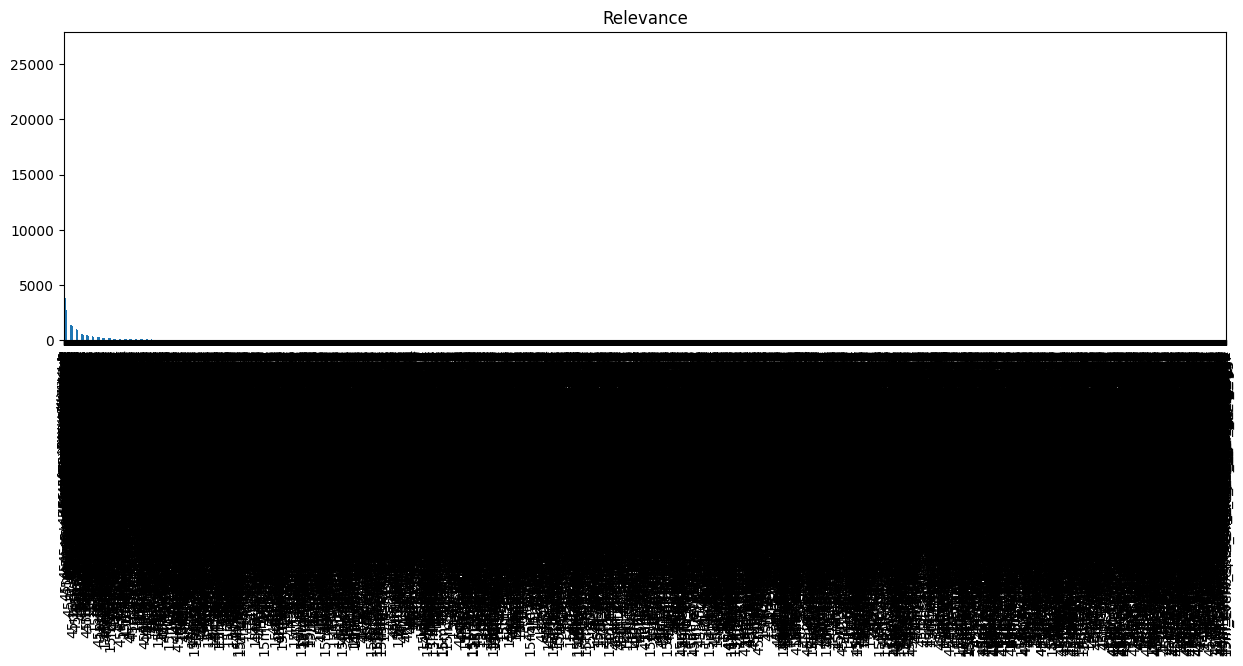

In [5]:
import matplotlib.pyplot as plt

if sel.__class__.__name__ == "SelectByInformationValue":
    side_res = pd.Series(iv_final).sort_values(ascending=False)
    side_res.plot.bar(figsize=(15, 4))
elif sel.__class__.__name__ == "MRMR":
    side_res = pd.Series(sel.relevance_, index=sel.variables_).sort_values(
        ascending=False
    )
    side_res.plot.bar(figsize=(15, 4))

plt.title("Relevance")
plt.show()

In [6]:
side_res

45m_williams_r                             2.661149e+04
45m_acc_swing_index_dt                     1.815520e+04
45m_trendflex_dt                           1.295715e+04
45m_fisher_dt                              1.252252e+04
45m_williams_r_dt                          9.464486e+03
                                               ...     
45m_dual_diff_lag30                        4.359391e-07
4h_vwap_ddt_lag7                           2.336137e-07
15m_vwap_dt_lag8                           4.131011e-08
15m_evenbetter_sinewave_short_ddt_lag17    3.296068e-08
45m_comb_spectrum_dom_cycle_ddt_lag31      1.422279e-08
Length: 11841, dtype: float64

In [7]:
len([k for k, v in side_res.to_dict().items() if v > 10])

2833

In [8]:
import json

with open(f"data/side_features_{sel.__class__.__name__}.json", "w") as f:
    json.dump(side_res.to_dict(), f, indent=4)

In [12]:
# import json
# import pandas as pd

# with open(f"data/side_features_MRMR.json", "r") as f:
#     side_res = pd.Series(json.load(f))

In [9]:
SHORT_TERM = "15m"
MEDIUM_TERM = "45m"
LONG_TERM = "4h"

feature_info = {
    "side": {SHORT_TERM: [], MEDIUM_TERM: [], LONG_TERM: []},
    "meta": {SHORT_TERM: [], MEDIUM_TERM: [], LONG_TERM: [], "model_res": []},
}

for k, v in side_res.to_dict().items():
    if v > 10:
        if k.startswith(f"{SHORT_TERM}_"):
            feature_info["side"][SHORT_TERM].append(k)
        elif k.startswith(f"{MEDIUM_TERM}_"):
            feature_info["side"][MEDIUM_TERM].append(k)
        elif k.startswith(f"{LONG_TERM}_"):
            feature_info["side"][LONG_TERM].append(k)

feature_info["side"][SHORT_TERM] = sorted(list(set(feature_info["side"][SHORT_TERM])))
feature_info["side"][MEDIUM_TERM] = sorted(list(set(feature_info["side"][MEDIUM_TERM])))
feature_info["side"][LONG_TERM] = sorted(list(set(feature_info["side"][LONG_TERM])))

feature_info["meta"][SHORT_TERM] = sorted(list(set(feature_info["meta"][SHORT_TERM])))
feature_info["meta"][MEDIUM_TERM] = sorted(list(set(feature_info["meta"][MEDIUM_TERM])))
feature_info["meta"][LONG_TERM] = sorted(list(set(feature_info["meta"][LONG_TERM])))
feature_info["meta"]["model_res"] = sorted(list(set(feature_info["meta"]["model_res"])))

with open("custom_indicators/feature_info.json", "w") as f:
    json.dump(feature_info, f, indent=4)

# meta model feature selection

In [ ]:
import lightgbm as lgb
import numpy as np
import pandas as pd

from custom_indicators.config import SIDE_ALL

df_features = pd.read_parquet("data/features_45m.parquet")
df_label = pd.read_parquet("data/label_meta_45m.parquet")

model_side = lgb.Booster(model_file="custom_indicators/models/model_side.txt")
model_side_res = model_side.predict(df_features[SIDE_ALL])
df_features["model_side_res"] = model_side_res
print(df_features.shape)

assert df_features.shape[0] == df_label.shape[0]
print(df_label.shape)
df_label.head()

In [ ]:
meta_features = df_features[583:]
meta_label = df_label["bin"][583:]

# meta_features = meta_features[meta_label["ret"].notna()]
# meta_label = meta_label[meta_label["ret"].notna()]["bin"]

print(meta_features.shape)
print(meta_label.shape)

meta_label.value_counts()

In [ ]:
# meta feature selection
from feature_engine.selection import MRMR

sel = MRMR(
    method="FCQ",
    max_features=meta_features.shape[1] // 2,
    scoring="f1",
    cv=4,
    regression=False,
    n_jobs=-1,
)
sel.fit(meta_features, meta_label)

In [ ]:
import matplotlib.pyplot as plt

pd.Series(sel.relevance_, index=sel.variables_).sort_values(ascending=False).plot.bar(
    figsize=(15, 4)
)
plt.title("Relevance")
plt.show()

In [ ]:
meta_res = pd.Series(sel.relevance_, index=sel.variables_).sort_values(ascending=False)
meta_res

In [6]:
import json

with open("data/mrmr_meta_features.json", "w") as f:
    json.dump(meta_res.to_dict(), f, indent=4)

In [5]:
import json
import pandas as pd

with open("data/mrmr_meta_features.json", "r") as f:
    meta_res = pd.Series(json.load(f))

In [ ]:
meta_res.to_dict()["model_side_res"]

In [ ]:
len([k for k, v in meta_res.to_dict().items() if v > 10])

In [8]:
from pathlib import Path

feature_info = Path("custom_indicators/feature_info.json")
if feature_info.exists():
    with open(feature_info, "r") as f:
        feature_info = json.load(f)

feature_info["meta"][SHORT_TERM] = []
feature_info["meta"][MEDIUM_TERM] = []
feature_info["meta"][LONG_TERM] = []
feature_info["meta"]["model_res"] = []

SHORT_TERM = "10m"
MEDIUM_TERM = "45m"
LONG_TERM = "4h"

for k, v in meta_res.to_dict().items():
    if v > 10:
        if k.startswith(f"{SHORT_TERM}_"):
            feature_info["meta"][SHORT_TERM].append(k)
            feature_info["all"].append(k.replace(f"{SHORT_TERM}_", ""))
        elif k.startswith(f"{MEDIUM_TERM}_"):
            feature_info["meta"][MEDIUM_TERM].append(k)
            feature_info["all"].append(k.replace(f"{MEDIUM_TERM}_", ""))
        elif k.startswith(f"{LONG_TERM}_"):
            feature_info["meta"][LONG_TERM].append(k)
            feature_info["all"].append(k.replace(f"{LONG_TERM}_", ""))
        else:
            feature_info["meta"]["model_res"].append(k)

feature_info["side"][SHORT_TERM] = sorted(list(set(feature_info["side"][SHORT_TERM])))
feature_info["side"][MEDIUM_TERM] = sorted(list(set(feature_info["side"][MEDIUM_TERM])))
feature_info["side"][LONG_TERM] = sorted(list(set(feature_info["side"][LONG_TERM])))

feature_info["meta"][SHORT_TERM] = sorted(list(set(feature_info["meta"][SHORT_TERM])))
feature_info["meta"][MEDIUM_TERM] = sorted(list(set(feature_info["meta"][MEDIUM_TERM])))
feature_info["meta"][LONG_TERM] = sorted(list(set(feature_info["meta"][LONG_TERM])))
feature_info["meta"]["model_res"] = sorted(list(set(feature_info["meta"]["model_res"])))

with open("custom_indicators/feature_info.json", "w") as f:
    json.dump(feature_info, f, indent=4)